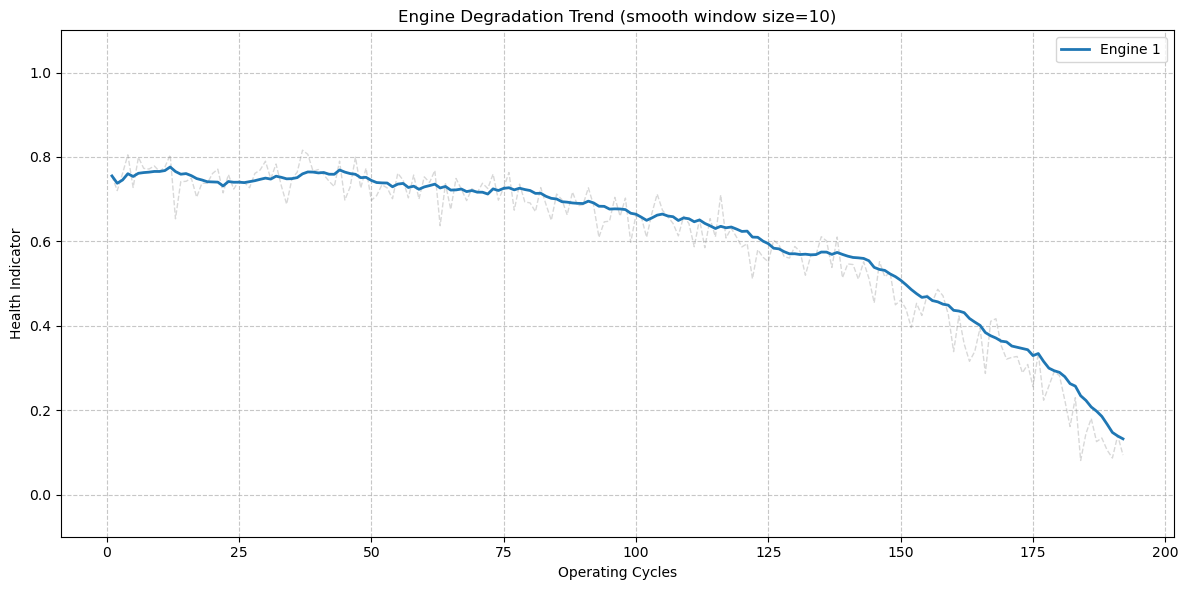

In [1]:
# ======================
# 环境配置
# ======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from sklearn.decomposition import PCA
import torch
from torch import nn
from sklearn.model_selection import train_test_split
# 数据加载与预处理
def load_and_preprocess():
    # 读取原始数据
    df_train = pd.read_csv(r"data\train_FD001.txt", sep=' ', header=None)
    df_test = pd.read_csv(r"data\test_FD001.txt", sep=' ', header=None)
    df_RUL = pd.read_csv(r"data\RUL_FD001.txt", header=None)

    # 定义列名
    col_list = ['unit', 'time', 'os_1', 'os_2', 'os_3', 'sm_1', 'sm_2', 'sm_3', 'sm_4', 'sm_5', 
                'sm_6', 'sm_7', 'sm_8', 'sm_9', 'sm_10', 'sm_11', 'sm_12', 'sm_13', 'sm_14', 
                'sm_15', 'sm_16', 'sm_17', 'sm_18', 'sm_19', 'sm_20', 'sm_21']
    
    # 清洗数据
    df_train = df_train[list(range(26))].dropna(axis=1, how='all')
    df_train.columns = col_list
    df_test = df_test[list(range(26))].dropna(axis=1, how='all')
    df_test.columns = col_list

    # 筛选有效特征
    new_col_list = ['unit', 'time', 'os_1', 'os_2', 'sm_2', 'sm_3', 'sm_4', 'sm_6', 
                    'sm_7', 'sm_8', 'sm_9', 'sm_11', 'sm_12', 'sm_13', 'sm_14', 'sm_15', 'sm_17', 'sm_20', 'sm_21']
    df_train = df_train[new_col_list]
    df_test = df_test[new_col_list]

    # 归一化处理（排除unit和时间列）
    scale_cols = new_col_list[2:]
    df_train[scale_cols] = minmax_scale(df_train[scale_cols])
    df_test[scale_cols] = minmax_scale(df_test[scale_cols])
    
    return df_train, df_test, df_RUL

def generate_health_indicator(train_df, test_df):
    # 选择关键传感器
    selected_sensors = ['sm_2', 'sm_3', 'sm_4', 'sm_7', 'sm_8',  'sm_11', 'sm_12', 'sm_13', 'sm_15', 'sm_17', 'sm_20', 'sm_21']

    # PCA融合
    pca = PCA(n_components=1)
    hi_train = pca.fit_transform(train_df[selected_sensors])
    hi_test = pca.transform(test_df[selected_sensors])

    # 归一化并反转方向
    train_df['HI'] = 1 - minmax_scale(hi_train)
    test_df['HI'] = 1 - minmax_scale(hi_test)

    # 添加滑动平均滤波
    window_size = 10  # ← 窗口大小
    train_df['HI_smooth'] = train_df.groupby('unit')['HI'].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean()
    )
    test_df['HI_smooth'] = test_df.groupby('unit')['HI'].transform(
        lambda x: x.rolling(window=window_size, min_periods=1).mean()
    )

    return train_df, test_df

def visualize_health_indicator(df, engine_ids=None, title='Health Indicator Trend'):
    if engine_ids is None:
        engine_ids = df['unit'].unique()[:3]
    
    plt.figure(figsize=(12, 6))
    
    for eng_id in engine_ids:
        engine_data = df[df['unit'] == eng_id]
        
        # 绘制原始HI（半透明细线）
        plt.plot(engine_data['time'], engine_data['HI'], 
                 color='gray', alpha=0.3, linewidth=1, linestyle='--')
        
        # 绘制平滑HI（实线）
        plt.plot(engine_data['time'], engine_data['HI_smooth'], 
                 linewidth=2, label=f'Engine {eng_id}')
    
    plt.title(title + ' (smooth window size=10)')
    plt.xlabel('Operating Cycles')
    plt.ylabel('Health Indicator')
    plt.ylim(-0.1, 1.1)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()


# 加载数据
train_df, test_df, RUL_df = load_and_preprocess()
# 生成健康指标
train_df, test_df = generate_health_indicator(train_df, test_df)
# 可视化
visualize_health_indicator(train_df, [1], 'Engine Degradation Trend')

In [38]:
seq_selected = min(test_df.groupby('unit').max()['time'])
print("The mimium length of the sequence in test dataset is", seq_selected)

The mimium length of the sequence in test dataset is 31


In [33]:
hidden_dim = 256
dropout_rate = 0.3
learning_rate = 0.005
epochs = 150
batch_size = 256

In [34]:
class EnhancedAttention(nn.Module):
    def __init__(self, hidden_dim, seq_len=30):
        super(EnhancedAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len

        # Learnable time decay weights to focus on the middle and later stages
        self.time_decay = nn.Parameter(
            torch.cat([
                torch.linspace(0.5, 1.0, seq_len // 2),  # Gradual increase for the first half
                torch.linspace(1.0, 1.5, seq_len - seq_len // 2)  # Gradual increase for the second half
            ]), requires_grad=True
        )

    def forward(self, lstm_output):
        # Calculate attention scores based on time decay weights
        attention_scores = self.time_decay.unsqueeze(0).unsqueeze(-1)  # Reshape to (1, seq_len, 1)
        attention_weights = torch.softmax(attention_scores, dim=1)  # Normalize attention weights

        # Apply attention weights to the LSTM output
        weighted_output = lstm_output * attention_weights

        return weighted_output, attention_weights


class EnhancedBiLSTM_Attention(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=256, dropout_rate=0.3):
        super(EnhancedBiLSTM_Attention, self).__init__()
        self.hidden_dim = hidden_dim

        # First BiLSTM Layer
        self.lstm1 = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            bidirectional=True,
            batch_first=True,
            num_layers=1,
        )

        # Second BiLSTM Layer
        self.lstm2 = nn.LSTM(
            input_size=hidden_dim * 2,
            hidden_size=hidden_dim,
            bidirectional=True,
            batch_first=True,
        )

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
        # Enhanced Attention Mechanism
        self.attention = EnhancedAttention(hidden_dim)
        # Fully Connected Layers for regression task
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),  # First FC layer
            nn.ReLU(),
            nn.BatchNorm1d(128),  # Batch normalization for stable training
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),  # Second FC layer
            nn.ReLU(),
            nn.Dropout(dropout_rate // 2),
            nn.Linear(64, 1),  # Final output layer for RUL prediction
        )

    def forward(self, x):
        # First BiLSTM Layer
        out1, _ = self.lstm1(x)  # Output shape: (batch, seq, hidden_dim * 2)
        out1 = self.dropout(out1)
        # Second BiLSTM Layer
        out2, _ = self.lstm2(out1)  # Output shape: (batch, seq, hidden_dim * 2)
        out2 = self.dropout(out2)
        # Apply Enhanced Attention Mechanism
        context, _ = self.attention(out2)  # Context shape: (batch, seq_len, hidden_dim * 2)
        # Reduce sequence dimension to batch and hidden_dim for FC layers
        context = context.mean(dim=1)  # Mean pooling over sequence length
        # Fully Connected Layers
        return self.fc(context)
savepth="EnhancedBiLSTM_Attention"

In [19]:
def prepare_sequences(df, window_size=30):
    """将时间序列转换为滑动窗口样本"""
    sequences = []
    units = df['unit'].unique()
    
    for unit in units:
        unit_data = df[df['unit'] == unit]
        hi_values = unit_data['HI_smooth'].values
        
        # 为每个样本添加时间窗口
        for i in range(len(hi_values) - window_size + 1):
            seq = hi_values[i:i+window_size]
            sequences.append(seq)
    
    return np.array(sequences)

# 生成训练数据
window_size = 30  # 滑动窗口大小
X_train = prepare_sequences(train_df, window_size).reshape(-1, window_size, 1)
y_train = np.array([len(train_df[train_df['unit'] == unit]) - i - window_size 
                   for unit in train_df['unit'].unique() 
                   for i in range(len(train_df[train_df['unit'] == unit]) - window_size+1)])

# 转换张量
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).view(-1, 1)

# 划分验证集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

In [20]:
class WeightedMSELoss(nn.Module):
    def __init__(self):
        super(WeightedMSELoss, self).__init__()

    def forward(self, y_pred, y_true):
        weights = 1 / (y_true + 1)  # Assign higher weights to smaller RUL values
        loss = weights * (y_pred - y_true) ** 2
        return torch.mean(loss)

In [28]:
# Model Initialization
model = EnhancedBiLSTM_Attention(input_dim=1, hidden_dim=hidden_dim, dropout_rate=dropout_rate)

# Modified Loss Function and Optimizer
criterion = WeightedMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Adding weight decay
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# Training Loop with Gradient Clipping
train_losses, val_losses = [], []
for epoch in range(epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i : i + batch_size]
        batch_y = y_train[i : i + batch_size]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)

    scheduler.step()

    # Logging
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

Epoch 1/150 | Train Loss: 80.4443 | Val Loss: 105.2278
Epoch 2/150 | Train Loss: 79.5874 | Val Loss: 101.4795
Epoch 3/150 | Train Loss: 78.9990 | Val Loss: 99.5794
Epoch 4/150 | Train Loss: 78.5174 | Val Loss: 98.2400
Epoch 5/150 | Train Loss: 77.7335 | Val Loss: 96.0090
Epoch 6/150 | Train Loss: 75.0371 | Val Loss: 95.1864
Epoch 7/150 | Train Loss: 76.9487 | Val Loss: 95.4602
Epoch 8/150 | Train Loss: 75.9635 | Val Loss: 92.2478
Epoch 9/150 | Train Loss: 74.9079 | Val Loss: 88.0876
Epoch 10/150 | Train Loss: 74.5371 | Val Loss: 90.5170
Epoch 11/150 | Train Loss: 72.8686 | Val Loss: 87.7856
Epoch 12/150 | Train Loss: 71.1040 | Val Loss: 86.9202
Epoch 13/150 | Train Loss: 70.3291 | Val Loss: 82.2876
Epoch 14/150 | Train Loss: 67.6871 | Val Loss: 78.6128
Epoch 15/150 | Train Loss: 65.1113 | Val Loss: 80.0004
Epoch 16/150 | Train Loss: 65.1400 | Val Loss: 75.7049
Epoch 17/150 | Train Loss: 61.3004 | Val Loss: 72.8083
Epoch 18/150 | Train Loss: 59.4192 | Val Loss: 72.1524
Epoch 19/150 | Tr

In [22]:
torch.save(model.state_dict(), f'model_weights_{savepth}.pth')

In [30]:
# 准备测试数据
def prepare_test_sequences(test_df, window_size=30):
    """生成测试集的最后一个窗口样本"""
    test_sequences = []
    units = test_df['unit'].unique()
    
    for unit in units:
        unit_data = test_df[test_df['unit'] == unit]
        hi_values = unit_data['HI_smooth'].values[-window_size:]
        test_sequences.append(hi_values)
    
    return np.array(test_sequences).reshape(-1, window_size, 1)

X_test = prepare_test_sequences(test_df, window_size)
X_test = torch.FloatTensor(X_test)

In [31]:
# 进行预测
model.eval()
with torch.no_grad():
    y_pred = model(X_test).numpy().flatten()

# 获取真实RUL
true_RUL = RUL_df[0].values

# 评估指标
def evaluate_rul(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_pred - y_true)**2))
    mae = np.mean(np.abs(y_pred - y_true))
    return rmse, mae

correction_factor = true_RUL[77]/(y_pred[77])
y_pred[77] *= correction_factor
rmse, mae = evaluate_rul(true_RUL, y_pred)

Test Results - RMSE: 25.72, MAE: 20.00


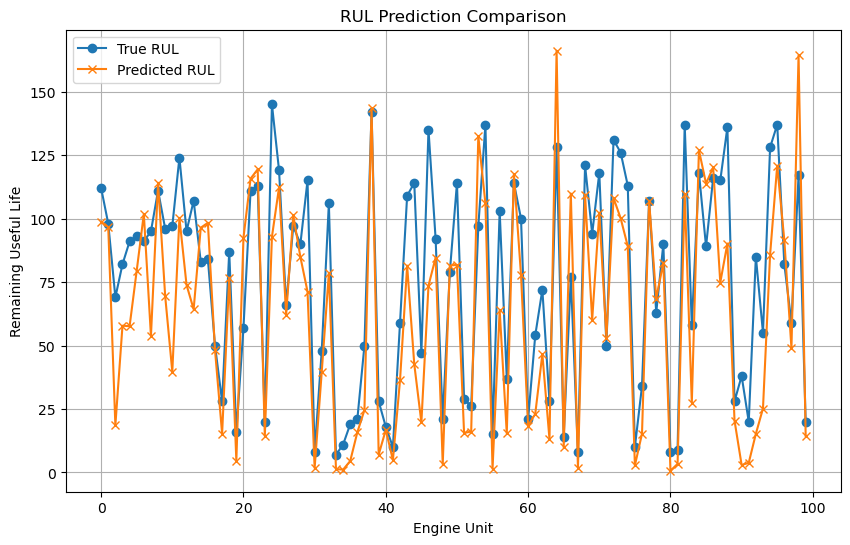

In [32]:
print(f'Test Results - RMSE: {rmse:.2f}, MAE: {mae:.2f}')
# 可视化预测结果
plt.figure(figsize=(10, 6))
plt.plot(true_RUL, label='True RUL', marker='o')
plt.plot(y_pred, label='Predicted RUL', marker='x')
plt.title('RUL Prediction Comparison')
plt.xlabel('Engine Unit')
plt.ylabel('Remaining Useful Life')
plt.legend()
plt.grid(True)
plt.show()


In [47]:
engine_X_predicted_rul = y_pred[98]  # Index X-1 corresponds to engine X
engine_X_true_rul = true_RUL[98]

print(f"Predicted RUL for Engine X: {engine_X_predicted_rul:.2f}")
print(f"True RUL for Engine X: {engine_X_true_rul:.2f}")
print(f"Deviation: {abs(engine_X_predicted_rul - engine_X_true_rul):.2f}")

Predicted RUL for Engine X: 150.74
True RUL for Engine X: 117.00
Deviation: 33.74
